# Testing the effect of satellites on profile measurement and mass determination

In [75]:
import sys
sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob
import random

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.stats import sigmaclip

from astropy.table import Table

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]
%matplotlib inline 
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
def display_maps(cen_sat_map, cen_map, pixel_scale):
    """
    Show the images of Illustris simulated galaxy.
    """
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(hspace=0.0, wspace=0.0,
                        top=1.0, right=1.0,
                        left=0.0, bottom=0.0)

    ax1 = plt.subplot(1, 3, 1)
    ax1 = display_single(cen_sat_map, ax=ax1,
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

    ax2 = plt.subplot(1, 3, 2)
    ax2 = display_single(cen_map, ax=ax2,
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)

    ax3 = plt.subplot(1, 3, 3)
    
    sat_map = (cen_sat_map - cen_map)#-(np.min(cen_sat_map - cen_map))
    ax3 = display_single(sat_map, ax=ax3,
                         contrast=0.15,
                         scale_bar_length=20.0,
                         scale_bar_loc='right',
                         stretch='log10',
                         pixel_scale=1.0,
                         physical_scale=pixel_scale,
                         color_bar=True)


    plt.show()


In [3]:
#load files
cen_profile_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_highres.pkl'
censat_profile_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_cen+sats_highres.pkl'

highres_cen_isos = load_pkl(cen_profile_file)
highres_censat_isos = load_pkl(censat_profile_file)

pixel_scale_highres = 1.0

In [4]:
#load files
cen_profile_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'
censat_profile_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_cen+sats_quick.pkl'

quick_cen_isos = load_pkl(cen_profile_file)
quick_censat_isos = load_pkl(censat_profile_file)

pixel_scale_quick = 5.333

# Plot profiles and differences for TNG galaxies

In [5]:
def mu_given_radial_bins(iso, pixel_scale, rmin=0.05, rmax=150, nbin=150):
    
    r_bins = np.linspace(rmin, rmax, nbin)
    intens = np.interp(r_bins, iso['sma'], iso['intens'])
    return 10**(np.log10(intens / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0))

def fractional_difference(profile_with_sats, profile_without_sats, pixel_scale, rmin=0.05, rmax=150, nbin=150):
    return (mu_given_radial_bins(profile_with_sats, pixel_scale, rmin, rmax, nbin)- \
            mu_given_radial_bins(profile_without_sats, pixel_scale, rmin, rmax, nbin))/\
            mu_given_radial_bins(profile_without_sats, pixel_scale, rmin, rmax, nbin)


#  highres

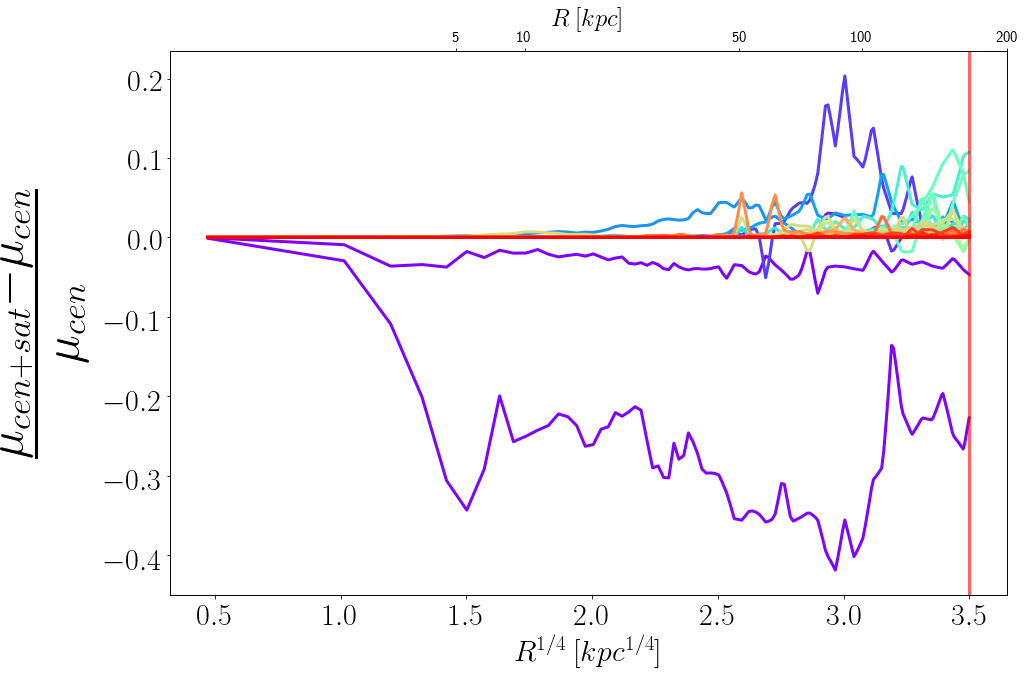

In [39]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_highres

rmin=0.05
rmax=150
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)

n = len(highres_censat_isos)
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(highres_censat_isos)): 
    
        profile_with_sats= highres_censat_isos[i]
        profile_without_sats= highres_cen_isos[i]


        mu_with_sats_plot = ax1.plot(r_bins ** 0.25,
                           (mu_given_radial_bins(profile_with_sats, pixel_scale)-mu_given_radial_bins(profile_without_sats, pixel_scale))/mu_given_radial_bins(profile_without_sats, pixel_scale), 
                           linewidth=3, alpha=1, zorder=1, color=next(color))
        
#         mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
#                            np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
#                            linewidth=2, alpha=1, label='Central only', zorder=1, 
#                            c=mu_with_sats_plot[0].get_color(), linestyle='--')



# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 4.5)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\frac{\mu_{cen+sat}-\mu_{cen}}{\mu_{cen}}$', fontsize=70)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(150.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

# ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_highres.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

for some reason galaxies 2 and 3 have more mass without satellites than with

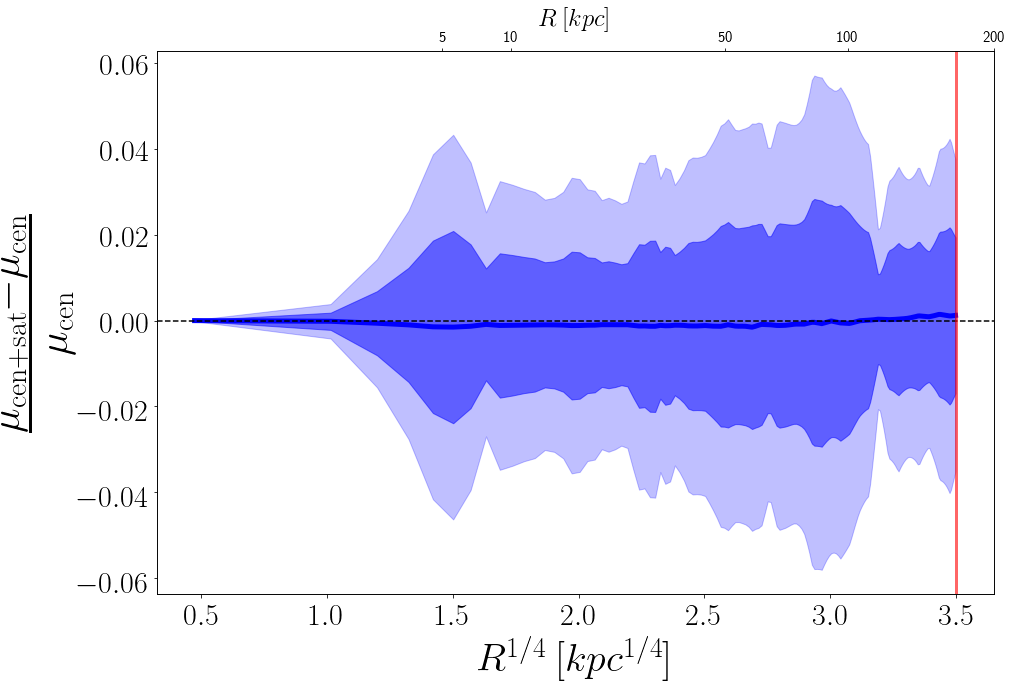

In [54]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_highres

rmin=0.05
rmax=150
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)

n = len(highres_censat_isos)
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))


difference = [fractional_difference(highres_censat_isos[i], highres_cen_isos[i], pixel_scale) for i in range(len(highres_censat_isos))]

median_difference = np.nanmedian(difference, axis=0)
mean_difference = np.nanmean(difference, axis=0)
std_difference = np.nanstd(difference, axis=0)
######################################################################################################################
# plot
######################################################################################################################



# ax1.plot(r_bins ** 0.25,median_difference, linewidth=5, alpha=0.5, zorder=1, color='k')
# ax1.fill_between(r_bins ** 0.25, median_difference+std_difference, median_difference-std_difference,
#                  alpha=0.25, zorder=1, color='k')

ax1.plot(r_bins ** 0.25, mean_difference, linewidth=5, alpha=1, zorder=1, color='b')
ax1.fill_between(r_bins ** 0.25, mean_difference+std_difference, mean_difference-std_difference,
                 alpha=0.5, zorder=1, color='b')
ax1.fill_between(r_bins ** 0.25, mean_difference+2*std_difference, mean_difference-2*std_difference,
                 alpha=0.25, zorder=1, color='b')

ax1.axhline(0, linestyle='--',color='k')
# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 4.5)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
ax1.set_ylabel(r'$\frac{\mu_{\mathrm{cen+sat}}-\mu_{\mathrm{cen}}}{\mu_{\mathrm{cen}}}$', fontsize=60, labelpad=-10)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(150.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')


######################################################################################################################
fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/fractional_difference_satellites_highres.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

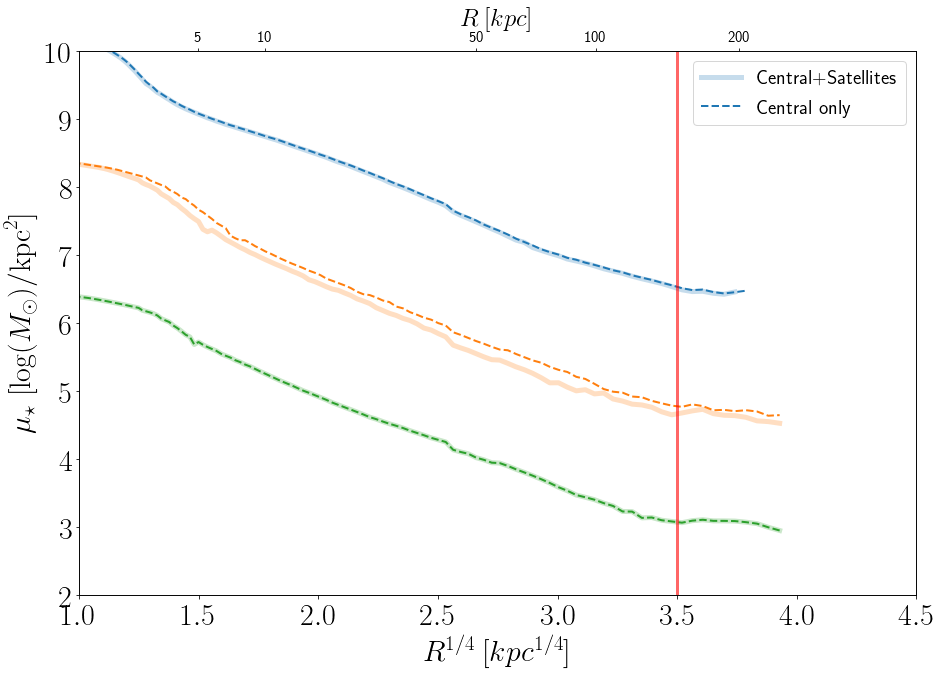

In [68]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_highres

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(highres_cen_isos[:3])): 
    
        profile_with_sats= highres_censat_isos[i]
        profile_without_sats= highres_cen_isos[i]


        mu_with_sats_plot = ax1.plot((profile_with_sats['sma_kpc']) ** 0.25,
                           np.log10(mu_iso(profile_with_sats, pixel_scale))-i*1.75, 
                           linewidth=5, alpha=0.25, label='Central+Satellites', zorder=1)
        
        mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
                           np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
                           linewidth=2, alpha=1, label='Central only', zorder=1, 
                           c=mu_with_sats_plot[0].get_color(), linestyle='--')



# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(1**0.25, 4.5)
ax1.set_ylim(2, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(150.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

# ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_highres.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

central mass: 2.38576494058e+12
satellites mass: 9.53232525424e+11
central mass: 1.39266075843e+12
satellites mass: 3.50209924464e+11
central mass: 1.65121385972e+12
satellites mass: 4.42027298755e+11


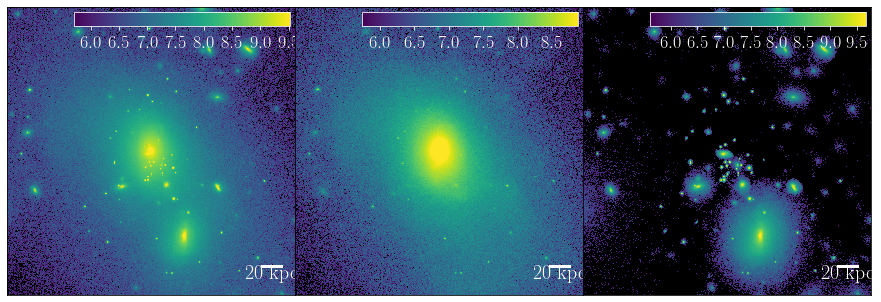

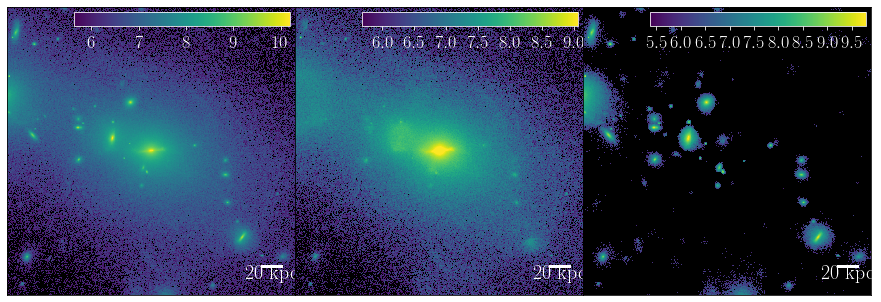

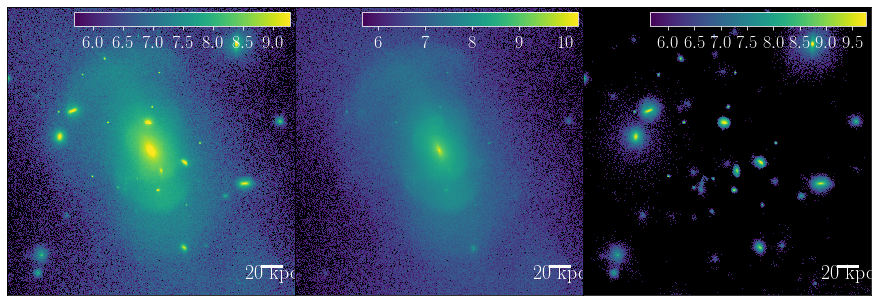

In [87]:
mass_maps = [get_mass_maps(TNG_file_highres, gal_n=i)[:2] for i in [0,1,2]]

for galaxy in mass_maps:
    cen_map = galaxy[0]
    censat_map = galaxy[1]
    sat_map = censat_map - cen_map
    display_maps(censat_map, cen_map, pixel_scale_highres)
    print("central mass: {0}".format(np.sum(cen_map)))
    print("satellites mass: {0}".format(np.sum(sat_map)))

# quick 

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in divide
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide


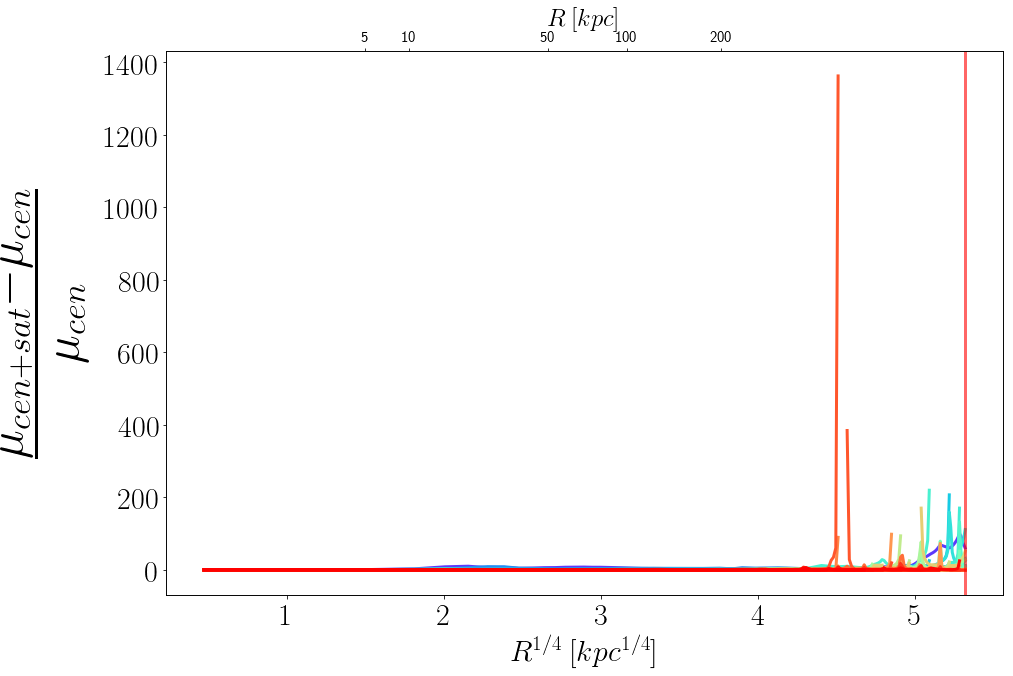

In [40]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_quick

rmin=0.05
rmax=800
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)

n = len(quick_censat_isos)
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(quick_censat_isos)): 
    
        profile_with_sats= quick_censat_isos[i]
        profile_without_sats= quick_cen_isos[i]


        mu_with_sats_plot = ax1.plot(r_bins ** 0.25,
                           (mu_given_radial_bins(profile_with_sats, pixel_scale, rmax=800)-mu_given_radial_bins(profile_without_sats, pixel_scale, rmax=800))/mu_given_radial_bins(profile_without_sats, pixel_scale, rmax=800), 
                           linewidth=3, alpha=1, zorder=1, color=next(color))
        
#         mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
#                            np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
#                            linewidth=2, alpha=1, label='Central only', zorder=1, 
#                            c=mu_with_sats_plot[0].get_color(), linestyle='--')



# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 4.5)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\frac{\mu_{cen+sat}-\mu_{cen}}{\mu_{cen}}$', fontsize=70)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

# ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_quick.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

a lot messiers with the quick maps, but at least it is the ones with satellites that have more mass

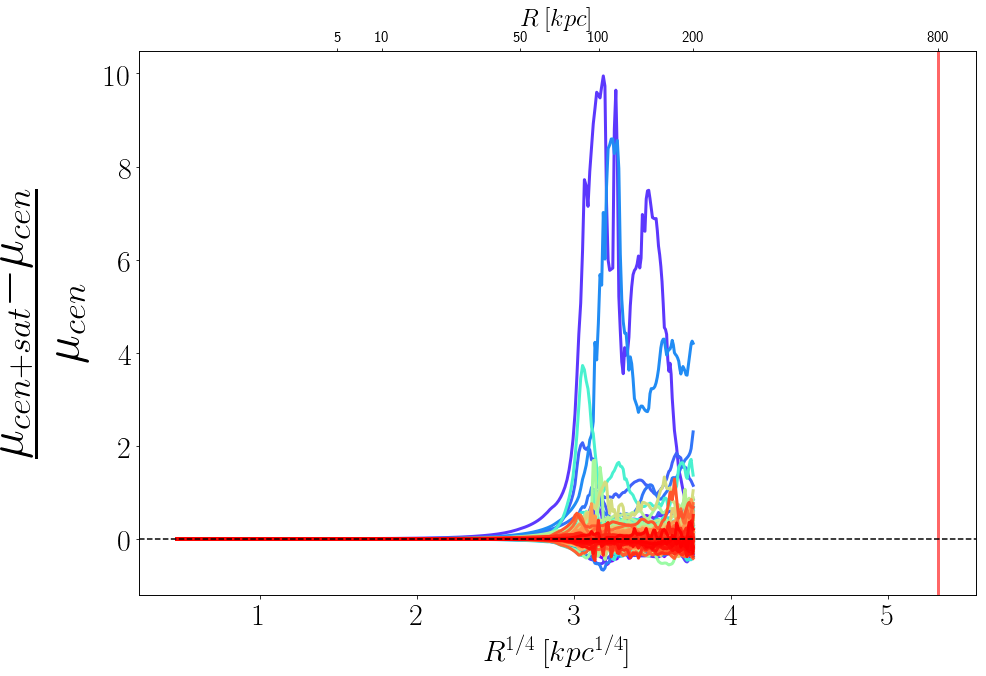

In [65]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_quick

rmin=0.05
rmax=200
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)

n = len(quick_censat_isos)
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(quick_censat_isos)): 
    
        profile_with_sats= quick_censat_isos[i]
        profile_without_sats= quick_cen_isos[i]


        mu_with_sats_plot = ax1.plot(r_bins ** 0.25,
                                    fractional_difference(profile_with_sats, profile_without_sats, pixel_scale, rmin, rmax, nbin),
                                    linewidth=3, alpha=1, zorder=1, color=next(color))
        
#         mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
#                            np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
#                            linewidth=2, alpha=1, label='Central only', zorder=1, 
#                            c=mu_with_sats_plot[0].get_color(), linestyle='--')

ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axhline(0, linestyle='--',color='k')

# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 4.5)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 800**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200, 800])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\frac{\mu_{cen+sat}-\mu_{cen}}{\mu_{cen}}$', fontsize=70)

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_quick.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

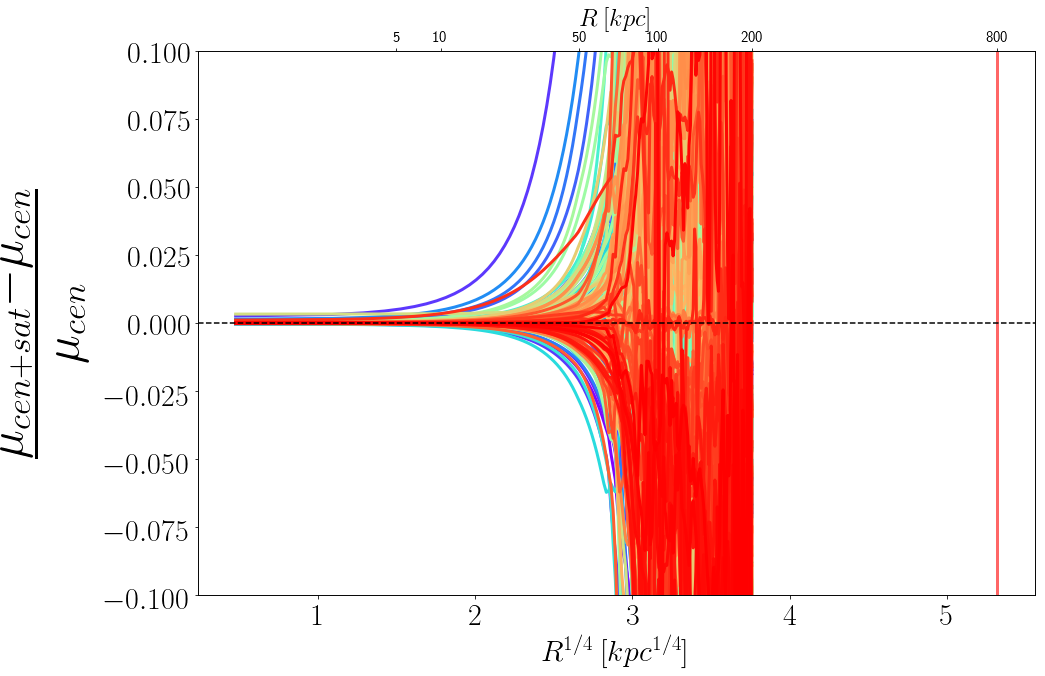

In [68]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_quick

rmin=0.05
rmax=200
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)

n = len(quick_censat_isos)
color=iter(plt.cm.rainbow(np.linspace(0,1,n)))

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(quick_censat_isos)): 
    
        profile_with_sats= quick_censat_isos[i]
        profile_without_sats= quick_cen_isos[i]


        mu_with_sats_plot = ax1.plot(r_bins ** 0.25,
                                    fractional_difference(profile_with_sats, profile_without_sats, pixel_scale, rmin, rmax, nbin),
                                    linewidth=3, alpha=1, zorder=1, color=next(color))
        
#         mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
#                            np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
#                            linewidth=2, alpha=1, label='Central only', zorder=1, 
#                            c=mu_with_sats_plot[0].get_color(), linestyle='--')

ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axhline(0, linestyle='--',color='k')

# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_ylim(-0.1, 0.1)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 800**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200, 800])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\frac{\mu_{cen+sat}-\mu_{cen}}{\mu_{cen}}$', fontsize=70)

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_quick.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

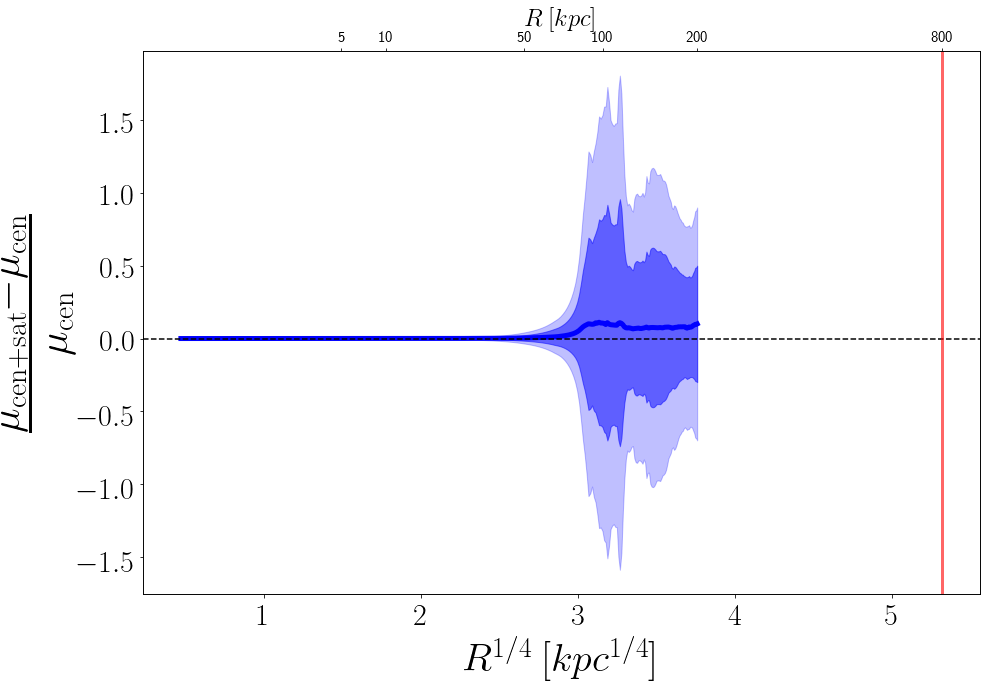

In [67]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_quick

rmin=0.05
rmax=200
nbin=150

r_bins = np.linspace(rmin, rmax, nbin)



difference = [fractional_difference(quick_censat_isos[i], quick_cen_isos[i], pixel_scale, rmin=rmin, rmax=rmax, nbin=nbin) for i in range(len(quick_censat_isos))]

median_difference = np.nanmedian(difference, axis=0)
mean_difference = np.nanmean(difference, axis=0)
std_difference = np.nanstd(difference, axis=0)
######################################################################################################################
# plot
######################################################################################################################



# ax1.plot(r_bins ** 0.25,median_difference, linewidth=5, alpha=0.5, zorder=1, color='k')
# ax1.fill_between(r_bins ** 0.25, median_difference+std_difference, median_difference-std_difference,
#                  alpha=0.25, zorder=1, color='k')

ax1.plot(r_bins ** 0.25, mean_difference, linewidth=5, alpha=1, zorder=1, color='b')
ax1.fill_between(r_bins ** 0.25, mean_difference+std_difference, mean_difference-std_difference,
                 alpha=0.5, zorder=1, color='b')
ax1.fill_between(r_bins ** 0.25, mean_difference+2*std_difference, mean_difference-2*std_difference,
                 alpha=0.25, zorder=1, color='b')

ax1.axhline(0, linestyle='--',color='k')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 4.5)
# ax1.set_ylim(-4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
# ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 800**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200, 800])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
ax1.set_ylabel(r'$\frac{\mu_{\mathrm{cen+sat}}-\mu_{\mathrm{cen}}}{\mu_{\mathrm{cen}}}$', fontsize=60, labelpad=-10)


######################################################################################################################
fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/fractional_difference_satellites_quick.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

plt.show()

was having trouble getting the average out to radius of 800kpc because some profiles drop off before that and result in an infinite fractional difference

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10


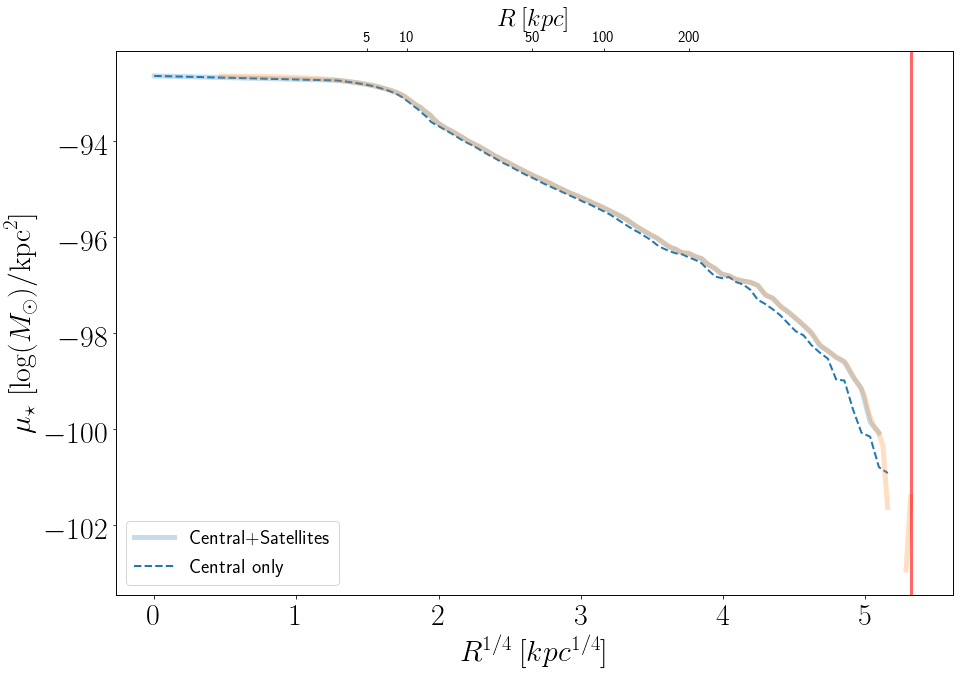

In [59]:
#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()

pixel_scale = pixel_scale_quick

######################################################################################################################
# plot
######################################################################################################################

for i in range(len(quick_censat_isos))[58:59]: 
    
        profile_with_sats = quick_censat_isos[i]
        profile_without_sats = quick_cen_isos[i]


        mu_with_sats_plot = ax1.plot((profile_with_sats['sma_kpc']) ** 0.25,
                           np.log10(mu_iso(profile_with_sats, pixel_scale))-i*1.75, 
                           linewidth=5, alpha=0.25, label='Central+Satellites', zorder=1)
        
        mu_without_sats_plot = ax1.plot((profile_without_sats['sma_kpc']) ** 0.25,
                           np.log10(mu_iso(profile_without_sats, pixel_scale))-i*1.75, 
                           linewidth=2, alpha=1, label='Central only', zorder=1, 
                           c=mu_with_sats_plot[0].get_color(), linestyle='--')

ax1.plot(np.linspace(0.05**0.25,800**0.25,150),
                           np.log10(mu_given_radial_bins(profile_with_sats, pixel_scale,rmax=800))-i*1.75, 
                           linewidth=5, alpha=0.25, label='Central+Satellites', zorder=1)

# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
# ax1.set_xlim(1**0.25, 6)
# ax1.set_ylim(-20, 10)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25])
ax1_twin.xaxis.set_ticklabels([5, 10, 50, 100, 200])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
# ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
# ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

# ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
# ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/masking_satellites_quick.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

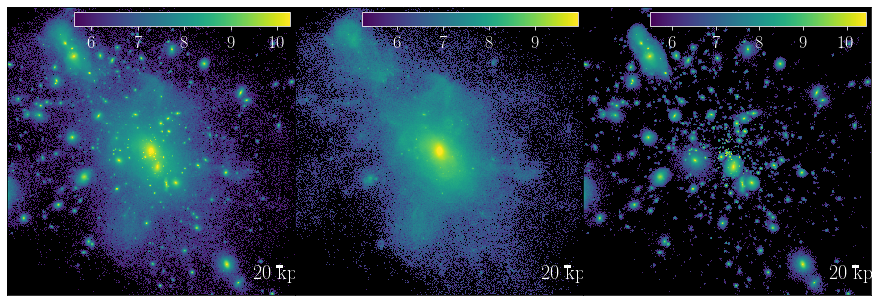

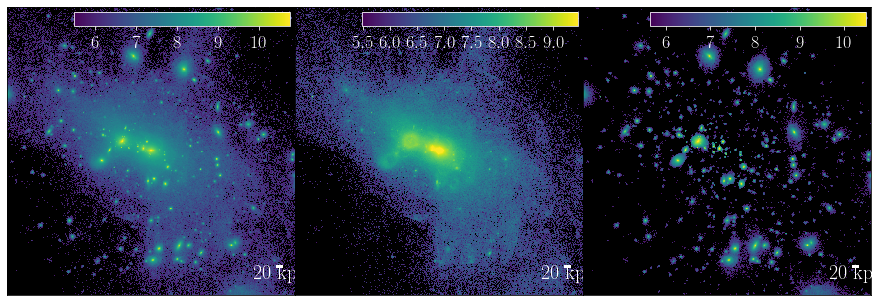

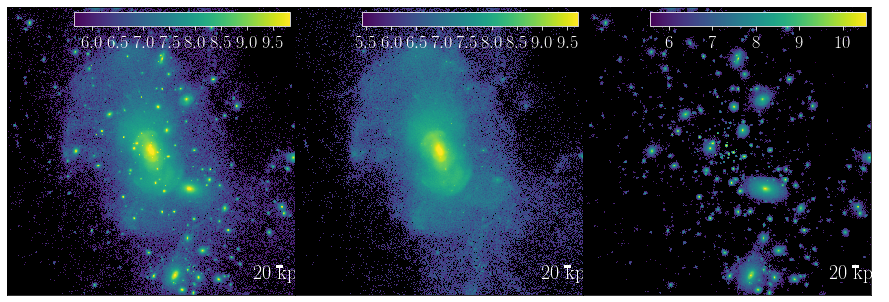

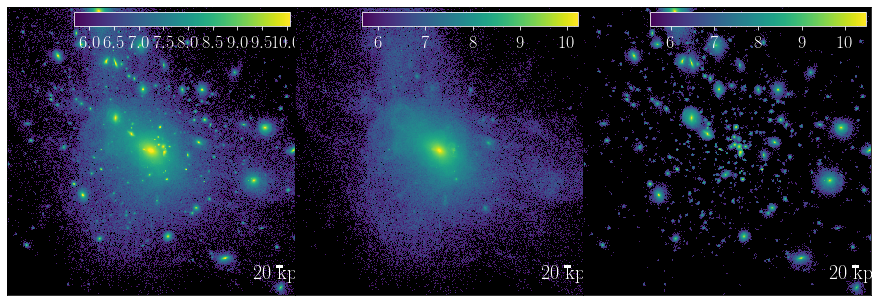

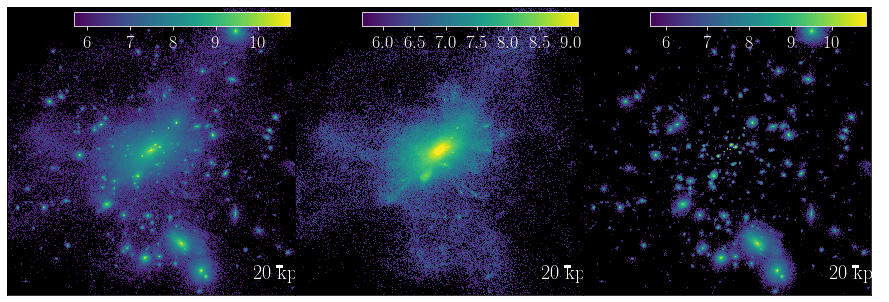

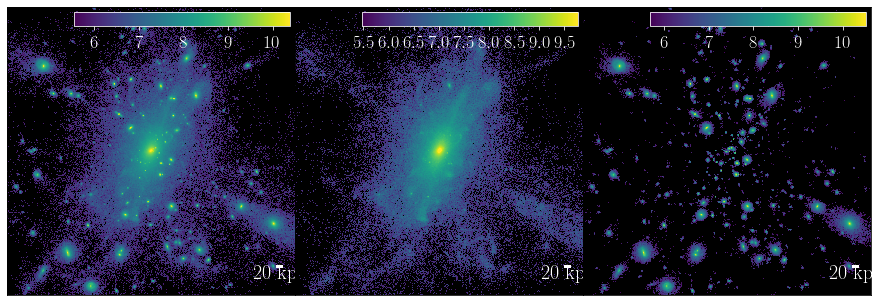

In [70]:
mass_maps = [get_mass_maps(TNG_file_quick, stars= 'all', gal_n=i)[:2] for i in [0,1,2,3,4,5]]

for galaxy in mass_maps:
    display_maps(galaxy[1], galaxy[0], pixel_scale_quick)

# Check Mass difference statistics

In [71]:
#load files
cen_mass_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
censat_mass_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_cen+sats_highres.pkl'

highres_cen_masses = load_pkl(cen_mass_file)
highres_censat_masses = load_pkl(censat_mass_file)

use 10sigma clipping to get rid of extreme outliers

In [97]:
M10_differences = sigmaclip(10**highres_censat_masses['m_1d_10'] - 10**highres_cen_masses['m_1d_10'], high=10, low=10)[0]
M30_differences = sigmaclip(10**highres_censat_masses['m_1d_30'] - 10**highres_cen_masses['m_1d_30'], high=10, low=10)[0]
M100_differences = sigmaclip(10**highres_censat_masses['m_1d_100'] - 10**highres_cen_masses['m_1d_100'], high=10, low=10)[0]


In [98]:
print('mean ; median ; std')
print('M10 differences: {0}; {1}; {2}'.format(round(np.mean(M10_differences),3),
                                              round(np.median(M10_differences),3),
                                              round(np.std(M10_differences),3)))
      
print('M30 differences: {0}; {1}; {2}'.format(round(np.mean(M30_differences),3),
                                              round(np.median(M30_differences),3),
                                              round(np.std(M30_differences),3)))
      
print('M100 differences: {0}; {1}; {2}'.format(round(np.mean(M100_differences),3),
                                              round(np.median(M100_differences),3),
                                              round(np.std(M100_differences),3)))
      

mean ; median ; std
M10 differences: 115916.073; 0.0; 571614.842
M30 differences: 952913.154; 0.0; 2921864.006
M100 differences: 52322165.522; 1141424.334; 279308928.275


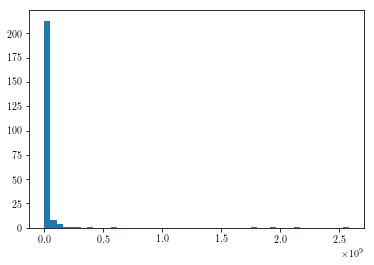

In [104]:
plt.hist(M100_differences, bins=50)
plt.show()

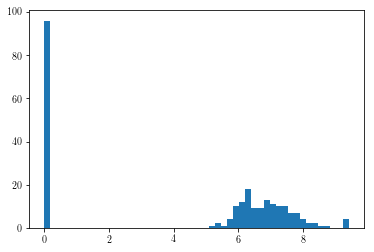

In [114]:
plt.hist(np.ma.log10(M100_differences).filled(0), bins=50)
plt.show()